# Mentions
#### Jan 2, 2021

## 1. Fetch data

In [132]:
import sqlalchemy
import configparser

# DB connection parameters
config = configparser.ConfigParser()
config.read('../db_config_final.ini')

host = config.get('database', 'host')
user = config.get('database', 'user')
passwd = config.get('database', 'passwd')


engine = sqlalchemy.create_engine('postgres://{0}:{1}@{2}:5432/{0}'.format(user, passwd, host, user))
meta = sqlalchemy.MetaData()
meta.reflect(bind=engine)

In [133]:
import pandas as pd

athletes_table = sqlalchemy.Table('athletes', meta, autoload=True)
q = athletes_table.select() # select query

dfa = pd.read_sql(q, engine)

In [134]:
posts_table = sqlalchemy.Table('posts', meta, autoload=True)
q = posts_table.select() # select query

dfp = pd.read_sql(q, engine)

In [135]:
dfp['performance_075xsigma'] = dfp['performance_075xsigma'].map({'normal': 'Typical performance', 'under': 'Underperformance', 'over': 'Overperformance'})

### Merge and select relevant columns

In [136]:
df = dfa.merge(dfp, how='right', left_on='id', right_on='author')[['gender', 'performance_075xsigma', 'name', 'handle_instagram', 'mentions']]

In [137]:
df.head()

gender performance_075xsigma                   name       handle_instagram  \
0      m      Underperformance              Beat Feuz                 feuz87   
1      f       Overperformance  Katharina Liensberger  liensberger.katharina   
2      f       Overperformance           Lindsey Vonn            lindseyvonn   
3      f      Underperformance           Lindsey Vonn            lindseyvonn   
4      f   Typical performance       Mikaela Shiffrin        mikaelashiffrin   

                                            mentions  
0                              [@are2019, @asvindal]  
1  [@are2019, @mikaelashiffrin, @annaswennlarsson...  
2                                                 []  
3  [@mikaelashiffrin, @iamsofiagoggia, @_corinnes...  
4             [@petravlhova13, @viktoria_rebensburg]

## 2. Mentions overview

In [138]:
df['n_mentions'] = df['mentions'].apply(len)

In [139]:
print('Average number of mentions per post:\n', df.groupby(['gender'])['n_mentions'].mean())

Average number of mentions per post:
 gender
f    1.918919
m    1.666667
Name: n_mentions, dtype: float64


In [140]:
print('Average number of mentions per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_mentions'].mean())

Average number of mentions per post:
 gender  performance_075xsigma
f       Overperformance          1.875000
        Typical performance      1.933333
        Underperformance         2.000000
m       Overperformance          1.533333
        Typical performance      2.333333
        Underperformance         0.833333
Name: n_mentions, dtype: float64


In [141]:
print('Std of number of mentions per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_mentions'].std())

Std of number of mentions per post:
 gender  performance_075xsigma
f       Overperformance          2.362908
        Typical performance      1.486447
        Underperformance         1.673320
m       Overperformance          1.807392
        Typical performance      1.571810
        Underperformance         1.114641
Name: n_mentions, dtype: float64


## 3. Relevant mentions

Identify mentions of other athletes ("approach II" below), whether they belong to the sample or not. Mentions of sponsors or similar are not relevant.

In [142]:
df.mentions.explode().nunique()

42

In [143]:
athlete_handles = ('@'+dfa.handle_instagram.dropna()).tolist()

mentions_not_in_sample = [mention for mention in df.mentions.explode().unique() if mention not in athlete_handles]

mentions_not_in_sample

['@are2019',
 '@rauch_happyday',
 '@rossignolracing',
 '@gepapictures',
 nan,
 '@dainesewinter',
 '@lalalaurenne',
 '@agencezoom',
 '@ntb_scanpix',
 '@stoeckli_1935',
 '@milka_dach',
 '@francesca_marsaglia',
 '@nadia_fanchini',
 '@skiteamswedenalpine',
 '@bildbyran',
 '@pentaphoto',
 '@stefanhadalin',
 '@falconeriofficial',
 '@fedfranceski',
 '@tignesofficiel',
 '@austriaskiteammen',
 '@briceroger',
 '@_nilsallegre_',
 '@sebastien_auer',
 '@worldcupstockholm']

In [144]:
mentions_to_exclude = ['@dainesewinter', '@agencezoom', '@are2019', '@ntb_scanpix','@stoeckli_1935','@milka_dach','@skiteamswedenalpine','@bildbyran','@pentaphoto',
 '@rauch_happyday','@rossignolracing','@gepapictures','@falconeriofficial','@fedfranceski','@tignesofficiel','@austriaskiteammen','@worldcupstockholm']

In [145]:
# APPROACH I: only keep mentions of athletes in sample
athlete_handles = ('@'+dfa.handle_instagram.dropna()).tolist()

def athlete_mentions(x):
    return([mention for mention in x if mention in athlete_handles])


# APPROACH II: keep mentions of all athletes
def all_athlete_mentions(x):
    return([mention for mention in x if mention not in mentions_to_exclude])


In [146]:
df['mentions_athletes'] = df['mentions'].apply(all_athlete_mentions)

In [147]:
df['n_mentions_athletes'] = df['mentions_athletes'].apply(len)

In [148]:
print('Average number of athlete mentions per post:\n', df.groupby(['gender'])['n_mentions_athletes'].mean())

Average number of athlete mentions per post:
 gender
f    1.324324
m    1.088889
Name: n_mentions_athletes, dtype: float64


In [149]:
print('Average number of athlete mentions per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_mentions_athletes'].mean())

Average number of athlete mentions per post:
 gender  performance_075xsigma
f       Overperformance          1.187500
        Typical performance      1.400000
        Underperformance         1.500000
m       Overperformance          0.866667
        Typical performance      1.722222
        Underperformance         0.416667
Name: n_mentions_athletes, dtype: float64


In [150]:
print('Std of number of athlete mentions per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_mentions_athletes'].std())

Std of number of athlete mentions per post:
 gender  performance_075xsigma
f       Overperformance          1.470544
        Typical performance      1.454058
        Underperformance         1.643168
m       Overperformance          1.355764
        Typical performance      1.319784
        Underperformance         0.900337
Name: n_mentions_athletes, dtype: float64


In [151]:
import altair as alt

base = alt.Chart(df).mark_boxplot(outliers=False, extent=1, size=10)

mentions_by_perf = base.encode(
    x = alt.X('n_mentions_athletes:Q'),
    y = alt.Y('performance_075xsigma:N', sort = ['Underperformance', 'Typical performance', 'Overperformance'], axis=alt.Axis(title=None))
).facet(row='gender:N')

mentions_by_sex = base.encode(
    y = alt.Y('gender:N', title=None),
    x = alt.X('n_mentions_athletes:Q', title=None),
    color=alt.Color('gender:N', legend=None)
)

mentions_by_perf | mentions_by_sex

alt.HConcatChart(...)

## 4. Women/Men network (athlete mentions only)

- There are no cross mentions between the female and male groups.
- The male group is disjoint into 2 graphs: speed and technical athletes.
- The female group is not disjoint
- The measures of density, degree, modularity all point to the female graph being more connected than the male graph
- Shiffrin has by far the highest betweennes centrality
- In the men's network, Schwarz and Hirscher tie for first but athletes are close
- Hubs/Authority results confirm what's already visible in the graphs. Interesting that Suter and Goggia turn out at the top of the authority ranking, beating Shiffrin

#### A note on the mentions used when creating the networks.

Should we only consider mentions of athletes belonging to the sample? Or of any athlete?

I did both and the main conclusions summarised above do not change.

Here I only show the results obtained when considering all athletes, whether in or outsize the sample. However, one should keep in mind that we are not collecting posts for out-of-sample athletes and therefore we do not have outcoming edges for them.


In [152]:
# explode on mentions_athletes
df_expl = df.explode('mentions_athletes').dropna().reset_index(drop=True).drop(columns=['n_mentions'], axis=1)

In [153]:
# correct a few things
df_expl['mentions_athletes'] = df_expl['mentions_athletes'].apply(lambda x: x.replace(',','') if x.endswith(',') else x)
df_expl['mentions_athletes'] = df_expl['mentions_athletes'].apply(lambda x: x.replace('!','') if x.endswith('!') else x)
df_expl['handle_instagram'] = '@' + df_expl['handle_instagram']

In [154]:
mentions_not_in_sample

['@are2019',
 '@rauch_happyday',
 '@rossignolracing',
 '@gepapictures',
 nan,
 '@dainesewinter',
 '@lalalaurenne',
 '@agencezoom',
 '@ntb_scanpix',
 '@stoeckli_1935',
 '@milka_dach',
 '@francesca_marsaglia',
 '@nadia_fanchini',
 '@skiteamswedenalpine',
 '@bildbyran',
 '@pentaphoto',
 '@stefanhadalin',
 '@falconeriofficial',
 '@fedfranceski',
 '@tignesofficiel',
 '@austriaskiteammen',
 '@briceroger',
 '@_nilsallegre_',
 '@sebastien_auer',
 '@worldcupstockholm']

In [155]:
name_map = dict(zip('@'+dfa.handle_instagram, dfa.name))
sex_map = dict(zip(dfa.name, dfa.gender))

# add out-of-sample athletes
name_map['@lalalaurenne'] =  "Laurenne Ross"
name_map['@francesca_marsaglia'] = "Francesca Marsaglia"
name_map['@nadia_fanchini'] = "Nadia Fanchini"
name_map['@stefanhadalin'] = "Stefan Hadalin"
name_map['@briceroger'] = "Brice Roger"
name_map['@_nilsallegre_'] = "Nils Allegre"
name_map['@sebastien_auer'] = "Sebastien Auer"

sex_map["Laurenne Ross"] =  "f"
sex_map["Francesca Marsaglia"] =  "f"
sex_map["Nadia Fanchini"] =  "f"
sex_map["Stefan Hadalin"] =  "m"
sex_map["Brice Roger"] =  "m"
sex_map["Nils Allegre"] =  "m"
sex_map["Sebastien Auer"] =  "m"


df_expl['mention_name'] = df_expl['mentions_athletes'].map(name_map) 
df_expl['mention_sex'] = df_expl['mention_name'].map(sex_map) 

In [156]:
df_expl.head()

gender performance_075xsigma                   name        handle_instagram  \
0      m      Underperformance              Beat Feuz                 @feuz87   
1      f       Overperformance  Katharina Liensberger  @liensberger.katharina   
2      f       Overperformance  Katharina Liensberger  @liensberger.katharina   
3      f       Overperformance  Katharina Liensberger  @liensberger.katharina   
4      f      Underperformance           Lindsey Vonn            @lindseyvonn   

                                            mentions  mentions_athletes  \
0                              [@are2019, @asvindal]          @asvindal   
1  [@are2019, @mikaelashiffrin, @annaswennlarsson...   @mikaelashiffrin   
2  [@are2019, @mikaelashiffrin, @annaswennlarsson...  @annaswennlarsson   
3  [@are2019, @mikaelashiffrin, @annaswennlarsson...     @petravlhova13   
4  [@mikaelashiffrin, @iamsofiagoggia, @_corinnes...   @mikaelashiffrin   

   n_mentions_athletes        mention_name mention_sex  
0                    1  Aksel Lund Svindal           m  
1                    3    Mikaela Shiffrin           f  
2                    3  Anna Swenn-Larsson           f  
3                    3        Petra Vlhová           f  
4                    3    Mikaela Shiffrin           f

### Generate networks

In [157]:
import networkx as nx

In [158]:
freq_f = df_expl[df_expl['gender']=='f'].groupby(['handle_instagram', 'mentions_athletes']).size().reset_index(name='weight')
freq_m = df_expl[df_expl['gender']=='m'].groupby(['handle_instagram', 'mentions_athletes']).size().reset_index(name='weight')

In [159]:
freq_f.head()

handle_instagram     mentions_athletes  weight
0    @_corinnesuter_       @iamsofiagoggia       1
1    @_corinnesuter_      @mikaelashiffrin       1
2  @annaswennlarsson      @mikaelashiffrin       1
3  @annaswennlarsson        @petravlhova13       1
4  @federicabrignone  @francesca_marsaglia       1

In [160]:
GF=nx.from_pandas_edgelist(freq_f, "handle_instagram", "mentions_athletes", ["weight"], create_using=nx.DiGraph())
GM=nx.from_pandas_edgelist(freq_m, "handle_instagram", "mentions_athletes", ["weight"], create_using=nx.DiGraph())

In [161]:
edges_weight_f = [GF[u][v]['weight'] for (u,v) in GF.edges()]
edges_weight_m = [GM[u][v]['weight'] for (u,v) in GM.edges()]

In [162]:
print("Number of nodes (FEMALE, MALE): ", len(GF.nodes()), len(GM.nodes()))
print("Number of edges (FEMALE, MALE): ", len(GF.edges()), len(GM.edges()))

Number of nodes (FEMALE, MALE):  20 25
Number of edges (FEMALE, MALE):  46 47


In [163]:
from graphviz import Digraph as GVDiGraph

def map_weight(x, old_weights, new_interval):
    new_weight = (x - min(old_weights)) * (new_interval[1]-new_interval[0]) / (max(old_weights)-min(old_weights)) + new_interval[0]
    return new_weight

GVF = GVDiGraph(format='svg', engine='dot', filename="mentions_athletes_f")
GVF.attr(rankdir='LR', size='20,20', ratio='auto', overlap="False", dpi="200")

for x in GF.edges(data=True):
    # **weight** may influence the way the grah is drawn
    # **penwidth** only impacts the appearence of thearrows
    # **colorscheme** and **color** can be used together to color edges based on weight (for example)
    # (note Brewer coloschemes are accepted)
    
    # use weights only to influence edge width (ideal solution for now)
    GVF.edge(x[0], x[1], penwidth=str(map_weight(x[2]['weight'], edges_weight_f, [1,3])))

for x in GF.nodes(data=True):
    edges = GF.degree(x[0])
    node_shape = ['ellipse', 'doublecircle'][edges > 5]
    GVF.node(x[0], shape=node_shape)
    
GVF.view()

'mentions_athletes_f.svg'

In [164]:
GVM = GVDiGraph(format='svg', engine='dot', filename="mentions_athletes_m")
GVM.attr(rankdir='LR', size='20,20', ratio='auto', overlap="False", dpi="200")

for x in GM.edges(data=True):
    # **weight** may influence the way the grah is drawn
    # **penwidth** only impacts the appearence of thearrows
    # **colorscheme** and **color** can be used together to color edges based on weight (for example)
    # (note Brewer coloschemes are accepted)
    
    # use weights only to influence edge width (ideal solution for now)
    GVM.edge(x[0], x[1], penwidth=str(map_weight(x[2]['weight'], edges_weight_m, [1,3])))

for x in GM.nodes(data=True):
    edges = GM.degree(x[0])
    node_shape = ['ellipse', 'doublecircle'][edges > 5]
    GVM.node(x[0], shape=node_shape)
    
GVM.view()

'mentions_athletes_m.svg'

### Compare the two networks: DEGREE DISTRIBUTION AND MEAN DEGREE

mean degree = total edges / total nodes

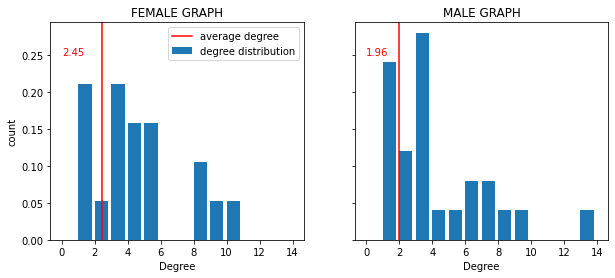

In [165]:
import collections
from matplotlib import pyplot as plt

degree_sequence_f = [d for n, d in GF.degree(weight='weight')]
degree_sequence_m = [d for n, d in GM.degree(weight='weight')]

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
ax[0].hist(degree_sequence_f, density=True, width=0.8, bins=range(0, 15), label='degree distribution')
ax[1].hist(degree_sequence_m, density=True, width=0.8, bins=range(0, 15))
ax[0].axvline(GF.size(weight='weight') / GF.order(), color='red', label='average degree') # average degree
ax[1].axvline(GM.size(weight='weight') / GM.order(), color='red') # average degree
ax[0].text(0, 0.25, round(GF.size(weight='weight') / GF.order(),2), color='red')
ax[1].text(0, 0.25, round(GM.size(weight='weight') / GM.order(),2), color='red')

ax[0].set(xlabel='Degree', ylabel='count', title='FEMALE GRAPH')
ax[1].set(xlabel='Degree', title='MALE GRAPH')
ax[0].legend()

### Compare the two networks: DENSITY

This is the ratio between the actual number of edges and the max possible amount of edges

In [166]:
nx.density(GF)

0.12105263157894737

In [167]:
nx.density(GM)

0.07833333333333334

### Compare the two networks: MODULARITY

Generate partitions (best_partition: modularity maximisation). Compute the modularity of these partitions (relative density of edges inside communities wrt edges outside communities). Modularity==1 corresponds to a fully modular cluster. Modularity==-0.5 corresponds to a non-modular clustering.

In [168]:
from community import community_louvain

parts_f = community_louvain.best_partition(GF.to_undirected())
parts_m = community_louvain.best_partition(GM.to_undirected())

In [169]:
community_dict_f = {}
for k,v in parts_f.items():
    community_dict_f[v] = community_dict_f.get(v, []) + [k]
    
community_dict_m = {}
for k,v in parts_m.items():
    community_dict_m[v] = community_dict_m.get(v, []) + [k]

In [170]:
community_dict_f

{0: ['@_corinnesuter_',
  '@iamsofiagoggia',
  '@ilkastuhec',
  '@lindseyvonn',
  '@itsstephanievenier',
  '@viktoria_rebensburg',
  '@nicischmidhofer',
  '@tessaworley'],
 1: ['@mikaelashiffrin',
  '@annaswennlarsson',
  '@petravlhova13',
  '@hansdotterfrida',
  '@liensberger.katharina',
  '@lalalaurenne',
  '@wendyholdener',
  '@ragmow',
  '@ramonasiebenhofer'],
 2: ['@federicabrignone', '@francesca_marsaglia', '@nadia_fanchini']}

In [171]:
community_dict_m

{0: ['@adrientheaux',
  '@_nilsallegre_',
  '@briceroger',
  '@sebastien_auer',
  '@yoclarey',
  '@dominikparis'],
 1: ['@alexispinturault',
  '@h_kristoffersen',
  '@marcel__hirscher',
  '@andremyhrer',
  '@mattmichi',
  '@schwarz_marco',
  '@leifhaugen',
  '@loicmeillard',
  '@manuel.feller.official',
  '@stefanhadalin',
  '@zankranjec'],
 2: ['@vincent__kriechmayr',
  '@feuz87',
  '@asvindal',
  '@hannesreichelt',
  '@innerhoferchristof',
  '@josef_ferstl',
  '@kjansrud',
  '@maurocaviezel']}

In [172]:
print("Modularity of women network: ",community_louvain.modularity(parts_f, GF.to_undirected()))

Modularity of women network:  0.3107277882797731


In [173]:
print("Modularity of men network: ",community_louvain.modularity(parts_m, GM.to_undirected()))

Modularity of men network:  0.5196124763705103


### Compare the two networks: NODE IMPORTANCE

I'm using **betweennes centrality** and **hub/authority values** as a measure for that.


- **betweennes centrality** (for a given node A): measures the proportion of shortest paths that pass through A and the total number of shortest paths (between any pair of nodes C and D in the graph).


- **Hub/Authority:** *Hyperlink-Induced Topic Search (HITS; also known as hubs and authorities) is a link analysis algorithm that rates Web pages, developed by Jon Kleinberg.[...]  a good hub represents a page that pointed to many other pages, while a good authority represents a page that is linked by many different hubs.* (Wikipedia)

For men, I consider the full (disjoint) graph as well as its components. For the centrality measure, only absolute values vary. For hub/authority, it seems the smallest component is ignored in the computation.

#### CENTRALITY: Women

In [174]:
bc_f = nx.betweenness_centrality(GF) # weight='weight'

for v,k in sorted(zip(bc_f.values(), bc_f.keys()), reverse=True):
    if v == 0:
        break
    print(f'{k}: {v}')

@mikaelashiffrin: 0.2149122807017544
@ragmow: 0.04093567251461988
@petravlhova13: 0.03654970760233918
@annaswennlarsson: 0.02631578947368421
@lindseyvonn: 0.023391812865497075


#### CENTRALITY: Men

In [175]:
components = [GM.subgraph(c).copy() for c in nx.connected_components(nx.Graph(GM))] # connected_components does not work on directed graphs --> nx.Graph(GM)

In [176]:
bc_m_full = nx.betweenness_centrality(GM)
bc_m_0 = nx.betweenness_centrality(components[0])
bc_m_1 = nx.betweenness_centrality(components[1])

print("---FULL GRAPH---")
for v,k in sorted(zip(bc_m_full.values(), bc_m_full.keys()), reverse=True):
    if v == 0:
        break
    print(f'{k}: {v}')
    
print("---COMPONENT 0---")
for v,k in sorted(zip(bc_m_0.values(), bc_m_0.keys()), reverse=True):
    if v == 0:
        break
    print(f'{k}: {v}')
    
print("---COMPONENT 1---")
for v,k in sorted(zip(bc_m_1.values(), bc_m_1.keys()), reverse=True):
    if v == 0:
        break
    print(f'{k}: {v}')

---FULL GRAPH---
@schwarz_marco: 0.019021739130434784
@marcel__hirscher: 0.018115942028985508
@h_kristoffersen: 0.01177536231884058
@alexispinturault: 0.005434782608695652
@vincent__kriechmayr: 0.0036231884057971015
---COMPONENT 0---
@vincent__kriechmayr: 0.01282051282051282
---COMPONENT 1---
@schwarz_marco: 0.11666666666666667
@marcel__hirscher: 0.11111111111111112
@h_kristoffersen: 0.07222222222222223
@alexispinturault: 0.03333333333333333


#### HUB/AUTHORITY: Women

In [177]:
hub_auth_f = nx.hits(GF)

print('---HUB VALUES---')
for v,k in sorted(zip(hub_auth_f[0].values(), hub_auth_f[0].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')
    
print('\n---AUTHORITY VALUES---')
for v,k in sorted(zip(hub_auth_f[1].values(), hub_auth_f[1].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')

---HUB VALUES---
@ilkastuhec: 0.1411037481439268
@mikaelashiffrin: 0.12965303026383793
@tessaworley: 0.10881020736669106
@itsstephanievenier: 0.10881020736669106
@ragmow: 0.09066508111435775
@nicischmidhofer: 0.09066508111435775
@lindseyvonn: 0.09066508111435775
@_corinnesuter_: 0.05837154033712202

---AUTHORITY VALUES---
@_corinnesuter_: 0.2183370850798208
@iamsofiagoggia: 0.20625840177035848
@mikaelashiffrin: 0.18839240647456265
@lindseyvonn: 0.12267945474509558
@petravlhova13: 0.08935219214018136


#### HUB/AUTHORITY: Men

In [178]:
hub_auth_m_full = nx.hits(GM)
hub_auth_m_0 = nx.hits(components[0])
hub_auth_m_1 = nx.hits(components[1])

print('---HUB VALUES---')
print('------FULL GRAPH')
for v,k in sorted(zip(hub_auth_m_full[0].values(), hub_auth_m_full[0].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')

print('------COMPONENT 0')
for v,k in sorted(zip(hub_auth_m_0[0].values(), hub_auth_m_0[0].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')
    
print('------COMPONENT 1')
for v,k in sorted(zip(hub_auth_m_1[0].values(), hub_auth_m_1[0].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')
    
print('\n---AUTHORITY VALUES---')
print('------FULL GRAPH')
for v,k in sorted(zip(hub_auth_m_full[1].values(), hub_auth_m_full[1].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')

print('------COMPONENT 0')
for v,k in sorted(zip(hub_auth_m_0[1].values(), hub_auth_m_0[1].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')
    
print('------COMPONENT 1')
for v,k in sorted(zip(hub_auth_m_1[1].values(), hub_auth_m_1[1].keys()), reverse=True):
    if v < 5e-2:
        break
    print(f'{k}: {v}')

---HUB VALUES---
------FULL GRAPH
@manuel.feller.official: 0.20139686131674797
@marcel__hirscher: 0.10754947037492153
@zankranjec: 0.1074412730556047
@loicmeillard: 0.1074412730556047
@leifhaugen: 0.1074412730556047
@h_kristoffersen: 0.09395558826114328
@andremyhrer: 0.09395558826114328
@alexispinturault: 0.0782345438410526
@mattmichi: 0.0720289819716097
------COMPONENT 0
@innerhoferchristof: 0.20888973584590878
@maurocaviezel: 0.1906262353340017
@josef_ferstl: 0.1906262353340017
@vincent__kriechmayr: 0.1524850448920892
@hannesreichelt: 0.10444486792295439
@feuz87: 0.10444486792295439
------COMPONENT 1
@manuel.feller.official: 0.20139686159993458
@marcel__hirscher: 0.10754947053109006
@zankranjec: 0.10744127328960819
@loicmeillard: 0.10744127328960819
@leifhaugen: 0.10744127328960819
@h_kristoffersen: 0.0939555883103264
@andremyhrer: 0.0939555883103264
@alexispinturault: 0.07823454398964809
@mattmichi: 0.07202898202549807

---AUTHORITY VALUES---
------FULL GRAPH
@marcel__hirscher: 0.30